## Important: Select Python Kernel

**Before running this notebook, make sure to select the correct Python kernel:**
1. Click on the kernel selector in the top-right corner of VS Code
2. Select: `.venv (Python 3.12.9)` or the virtual environment in this project folder
3. Do NOT use Python 3.14 as it has compatibility issues with networkx/pm4py

# DFG Visualization - Simulated Log

This notebook visualizes the Directly-Follows Graph (DFG) of the simulated event log.

In [1]:
# Import required libraries
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.statistics.start_activities.log import get as start_activities
from pm4py.statistics.end_activities.log import get as end_activities
import warnings
warnings.filterwarnings('ignore')

## 1. Load Simulated Log

In [3]:
# Load the simulated log
log_path = 'simulated_log_100.csv'

# Read CSV
df = pd.read_csv(log_path)

# Display basic info
print(f"Number of events: {len(df)}")
print(f"Number of cases: {df['case_id'].nunique()}")
print(f"Number of activities: {df['activity'].nunique()}")
print(f"\nFirst few rows:")
df.head()

Number of events: 3066


KeyError: 'case_id'

## 2. Convert to PM4Py Event Log

In [4]:
# Standardize column names for PM4Py
df_pm4py = df.copy()

# Rename columns to PM4Py standard
column_mapping = {
    'case_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp',
    'resource': 'org:resource'
}

for old_col, new_col in column_mapping.items():
    if old_col in df_pm4py.columns:
        df_pm4py.rename(columns={old_col: new_col}, inplace=True)

# Convert timestamp to datetime
df_pm4py['time:timestamp'] = pd.to_datetime(df_pm4py['time:timestamp'], format='mixed')

# Sort by case and timestamp
df_pm4py = df_pm4py.sort_values(['case:concept:name', 'time:timestamp'])

# Convert to event log
event_log = log_converter.apply(df_pm4py)

print(f"Event log created with {len(event_log)} cases")

Event log created with 100 cases


## 3. Discover DFG

In [5]:
# Discover DFG
dfg = dfg_discovery.apply(event_log)

# Get start and end activities
start_acts = start_activities.get_start_activities(event_log)
end_acts = end_activities.get_end_activities(event_log)

# Display statistics
print(f"Number of edges in DFG: {len(dfg)}")
print(f"\nTop 10 most frequent edges:")
sorted_dfg = sorted(dfg.items(), key=lambda x: x[1], reverse=True)[:10]
for (source, target), count in sorted_dfg:
    print(f"  {source} → {target}: {count}")

print(f"\nStart activities:")
for act, count in sorted(start_acts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {act}: {count}")

print(f"\nEnd activities:")
for act, count in sorted(end_acts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {act}: {count}")

Number of edges in DFG: 102

Top 10 most frequent edges:
  W_Assess potential fraud → W_Assess potential fraud: 1334
  W_Call after offers → W_Call after offers: 171
  W_Call incomplete files → W_Call incomplete files: 130
  W_Complete application → W_Complete application: 115
  O_Create Offer → O_Created: 86
  O_Cancelled → O_Cancelled: 86
  W_Complete application → A_Concept: 84
  W_Complete application → W_Call after offers: 80
  A_Create Application → W_Complete application: 77
  A_Accepted → O_Create Offer: 74

Start activities:
  A_Create Application: 100

End activities:
  W_Call after offers: 91
  O_Cancelled: 5
  W_Validate application: 2
  W_Call incomplete files: 1
  O_Create Offer: 1


## 4. Visualize DFG (Frequency)

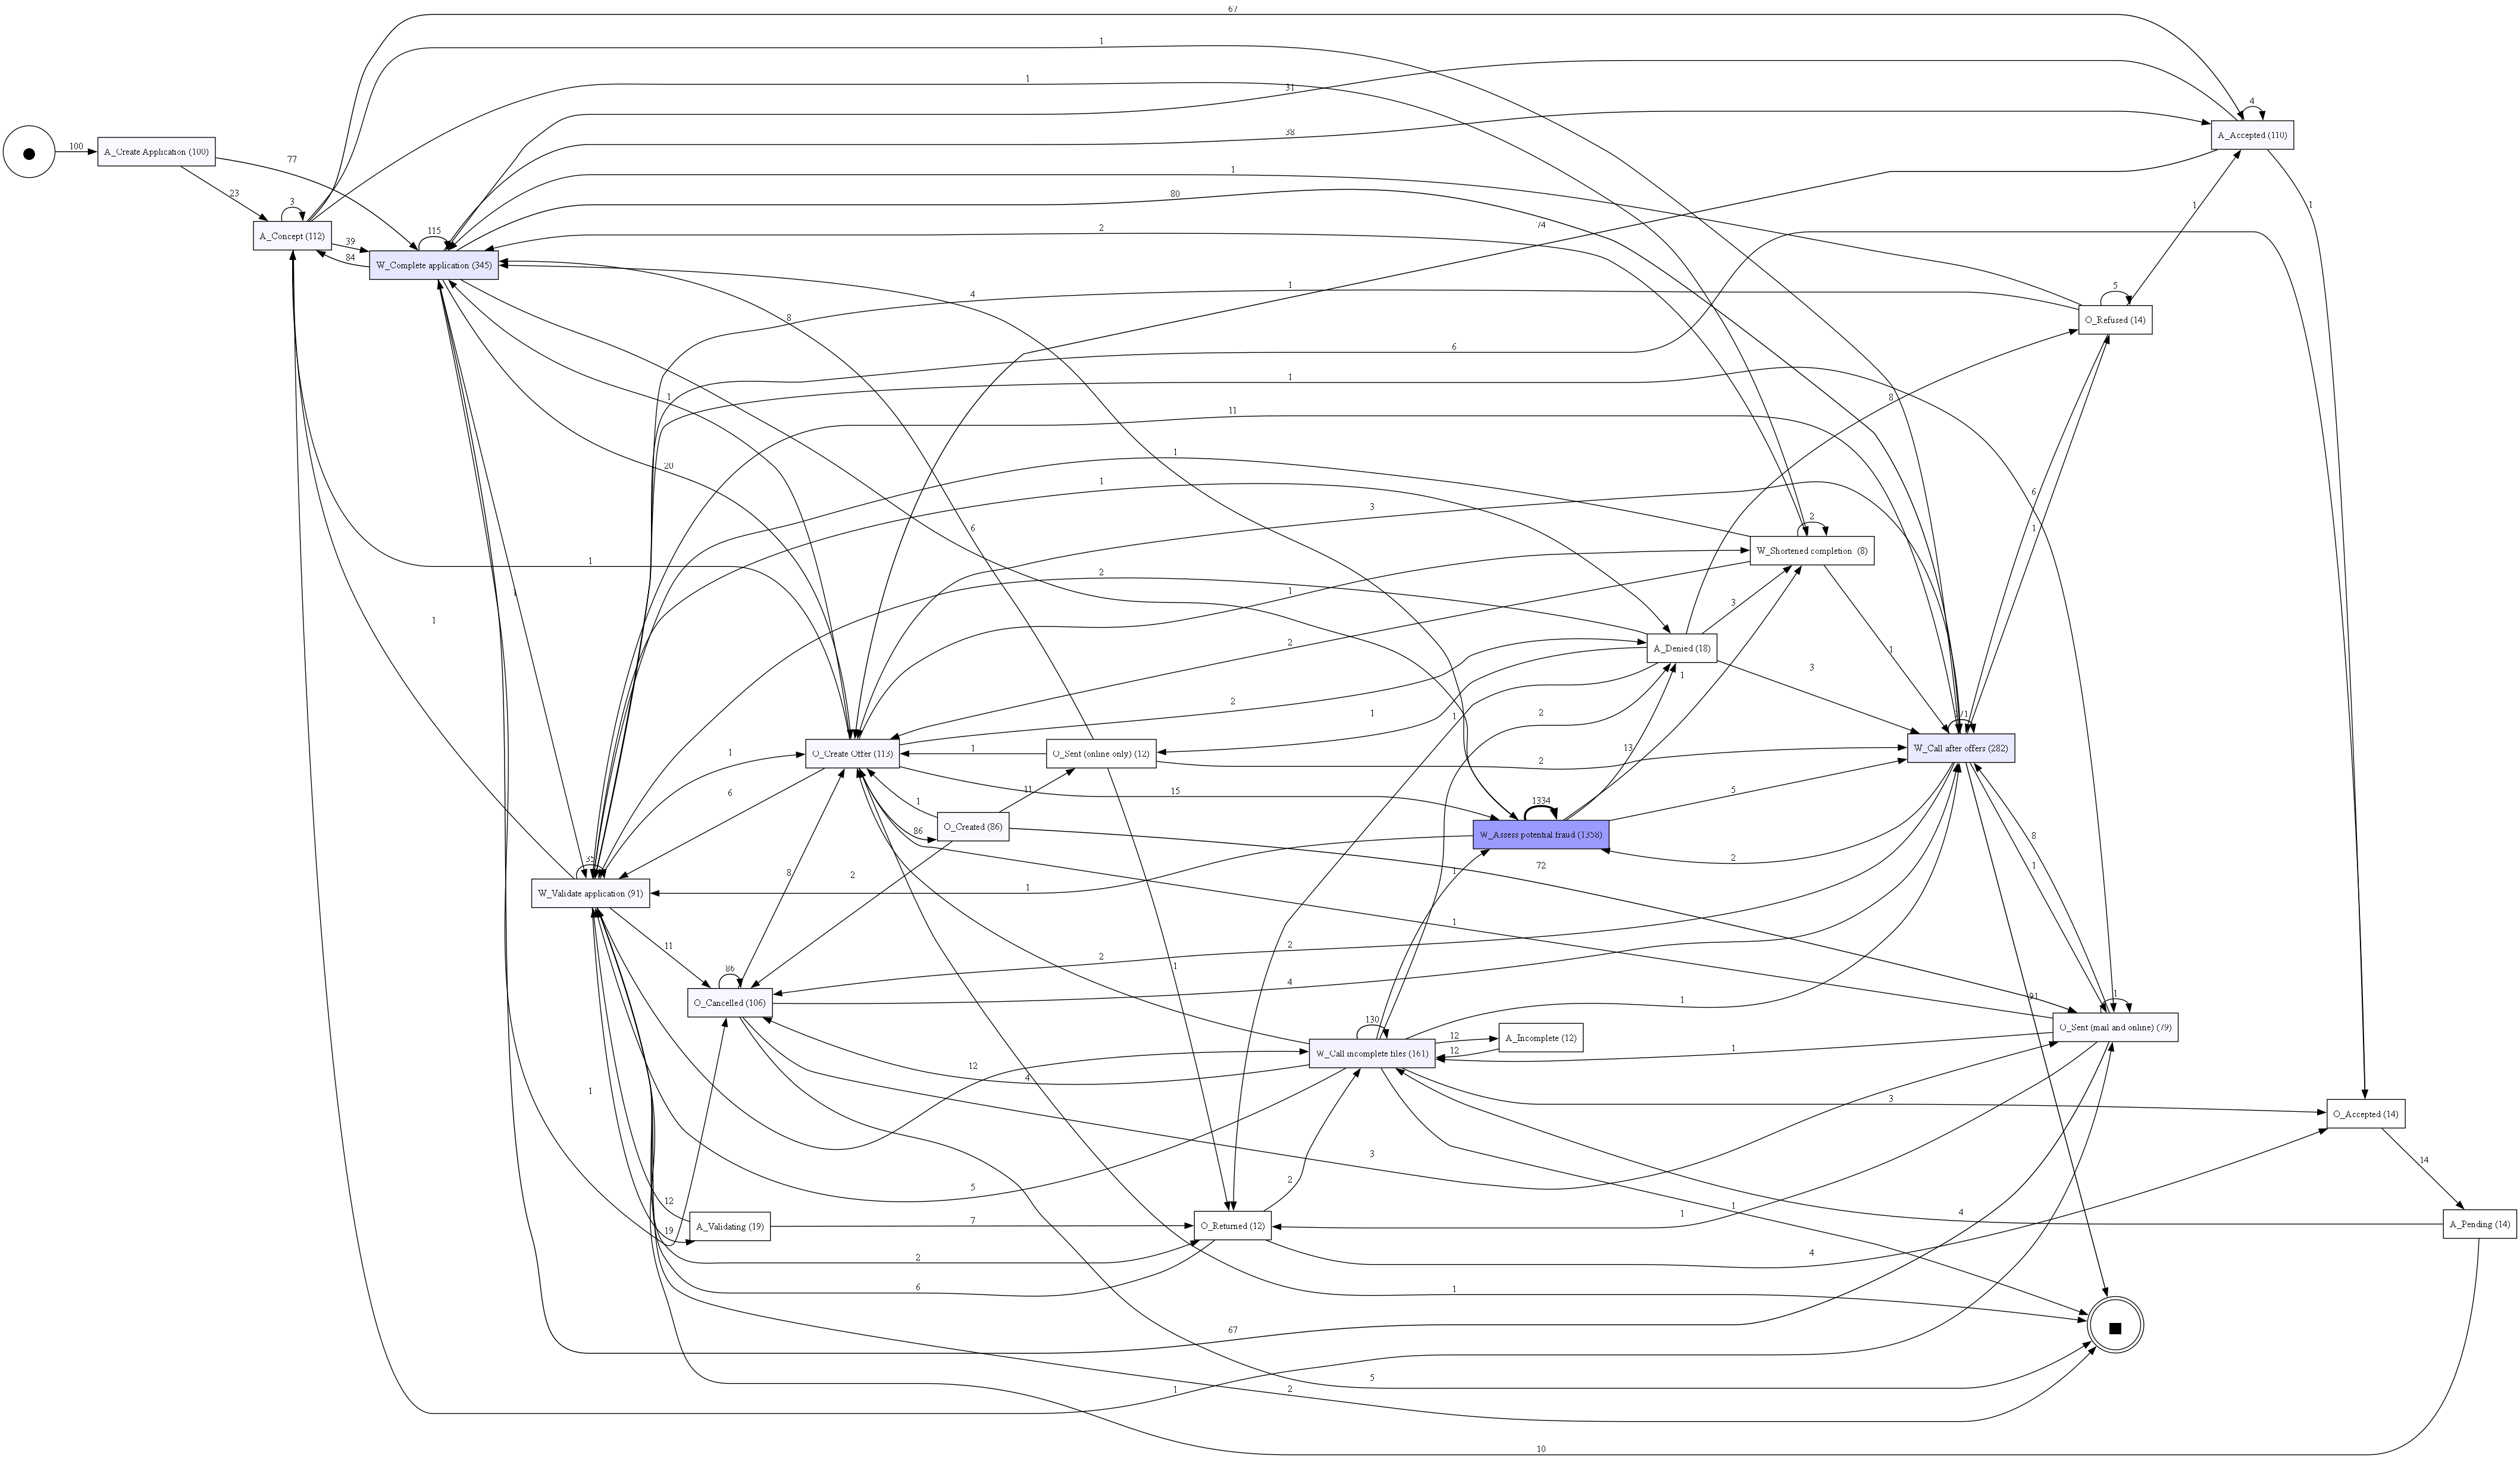

In [6]:
# Visualize DFG with frequency
parameters = {
    dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: 'png',
    dfg_visualization.Variants.FREQUENCY.value.Parameters.START_ACTIVITIES: start_acts,
    dfg_visualization.Variants.FREQUENCY.value.Parameters.END_ACTIVITIES: end_acts
}

gviz_freq = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
dfg_visualization.view(gviz_freq)

## 5. Visualize DFG (Performance - Average Duration)

In [ ]:
# Discover performance DFG
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

dfg_performance = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.PERFORMANCE)

# Visualize performance DFG
parameters_perf = {
    dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: 'png',
    dfg_visualization.Variants.PERFORMANCE.value.Parameters.START_ACTIVITIES: start_acts,
    dfg_visualization.Variants.PERFORMANCE.value.Parameters.END_ACTIVITIES: end_acts
}

gviz_perf = dfg_visualization.apply(dfg_performance, log=event_log, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters_perf)
dfg_visualization.view(gviz_perf)

## 6. Activity Frequency Statistics

In [ ]:
# Activity frequency
activity_counts = df['activity'].value_counts()

print("Activity Frequencies:")
print(activity_counts)

# Visualize with bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
activity_counts.plot(kind='bar')
plt.title('Activity Frequency in Simulated Log')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Variant Analysis

In [ ]:
# Extract variants
from pm4py.statistics.variants.log import get as variants_module

variants = variants_module.get_variants(event_log)

print(f"Total number of variants: {len(variants)}")
print(f"\nTop 10 most frequent variants:")

sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:10]
for i, (variant, cases) in enumerate(sorted_variants, 1):
    print(f"\nVariant {i} (Frequency: {len(cases)}):")
    print(f"  {' → '.join(variant)}")

## 8. Export DFG Images

In [ ]:
# Save DFG visualizations
dfg_visualization.save(gviz_freq, 'dfg_frequency.png')
dfg_visualization.save(gviz_perf, 'dfg_performance.png')

print("DFG images saved:")
print("  - dfg_frequency.png")
print("  - dfg_performance.png")